# Enhancer strength and gene correlation
"The sum of the enhancer strengths per gene correlated well with gene expression levels on average" - Stark paper

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
meta_df = pd.read_csv("/data5/deepro/starrseq/papers/results/1_categorize_fragments_on_activity/data/meta_activity_map.csv")

In [3]:
ko_lines = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [4]:
def get_enhancer_to_gene_maps(filename):
    df = pd.read_csv(filename, sep="\t")
    df["enhancer_id"] = df.chr + "_" + df.start.astype(str) + "_" + df.end.astype(str)
    return df.loc[:, ["enhancer_id", "TargetGene"]]

def get_tpm_normalized_gene_expression(filename):
    df = pd.read_csv(filename, sep="\t", index_col=[0, 1], skipfooter=5, engine="python")
    df = (df*1e6/df.sum()).mean(axis=1)
    return df

def get_meta_gene_exp_df(store_dir, ko_lines):
    df_list = []
    for ko in ko_lines:
        exp_file = os.path.join(store_dir, ko, "counts.tsv")
        exp_df = get_tpm_normalized_gene_expression(exp_file)
        df_list.append(exp_df)
    exp_df = pd.concat(df_list, axis=1)
    exp_df.columns = ko_lines
    return exp_df.reset_index()

def add_enhancer_activity(enhancer_mapped_df, meta_df, ko_lines):
    # select fragments that were starrpeaker peaks and induced in any one line :: these fragments have enhancer potential
    query = " | ".join([f"(`{ko}_peak` == 1)" for ko in ko_lines])
    meta_df = meta_df.query(query)
    df = enhancer_mapped_df.merge(meta_df, left_on="enhancer_id", right_on="chrom_coord")
    return df.loc[:, ['enhancer_id', 'TargetGene', 'chrom_coord'] +  ko_lines]

In [5]:
store_dir = "/data5/deepro/starrseq/papers/results/4_compare_expression_ko_vs_wt/data/results/count/"

In [6]:
exp_df = get_meta_gene_exp_df(store_dir, ko_lines)

In [7]:
# filter df
exp_df = exp_df.loc[exp_df.loc[:, ko_lines].sum(axis=1)>80]

In [8]:
prediction_types = ["activity_from_chip_nohic", "activity_from_chip_with_hic", "activity_from_starr_nohic", "activity_from_starr_with_hic"]
agg_func_dict = {"enhancer_id": lambda x: ",".join(x), "chrom_coord": lambda x: ",".join(x)}
agg_func_dict.update({f"{ko}_act":np.sum for ko in ko_lines})
groupby_list = ["TargetGene", "gene_id", "gene_name"] +[f"{ko}_exp" for ko in ko_lines]

for pt in prediction_types:
    enhancer_mapped_file = os.path.join(f"/data5/deepro/starrseq/papers/results/5_link_da_enhancers_to_de_genes/data/predictions/{pt}/EnhancerPredictionsFull.txt")
    enhancer_mapped_df = get_enhancer_to_gene_maps(enhancer_mapped_file)
    enhancer_mapped_with_activity = add_enhancer_activity(enhancer_mapped_df, meta_df, ko_lines)
    enhancer_mapped_with_activity_with_expression = enhancer_mapped_with_activity.merge(exp_df, left_on="TargetGene", right_on="gene_id", suffixes=("_act", "_exp"))    
    gene_with_enhancer_df = enhancer_mapped_with_activity_with_expression.groupby(groupby_list).aggregate(agg_func_dict).reset_index()
    expression_df = gene_with_enhancer_df.melt(id_vars=["enhancer_id", "gene_id", "gene_name"], value_vars=[f"{ko}_exp" for ko in ko_lines], value_name="exp", var_name="ko")
    activity_df = gene_with_enhancer_df.melt(id_vars=["enhancer_id", "gene_id", "gene_name"], value_vars=[f"{ko}_act" for ko in ko_lines], value_name="act", var_name="ko")
    print(pt)
    print(activity_df.act.corr(expression_df.exp))

activity_from_chip_nohic
-0.013357625174193484
activity_from_chip_with_hic
-0.06592433030342705
activity_from_starr_nohic
-0.006494616782369021
activity_from_starr_with_hic
-0.012878143976056283


In [9]:
def get_per_gene_corr(ser, ko_lines):
    act_val = ser.loc[[f"{ko}_act" for ko in ko_lines]].values
    exp_val = ser.loc[[f"{ko}_exp" for ko in ko_lines]].values
    return pearsonr(act_val, exp_val)[0]

In [10]:
gene_with_enhancer_df["per_gene_corr"] = gene_with_enhancer_df.apply(get_per_gene_corr, args=(ko_lines,), axis=1)

In [11]:
save_file = "/data5/deepro/starrseq/papers/results/5_link_da_enhancers_to_de_genes/data/activity_vs_expression_corr/da_de_corr_table.csv"
gene_with_enhancer_df.sort_values("per_gene_corr", ascending=False).to_csv(save_file)

<AxesSubplot:xlabel='act', ylabel='exp'>

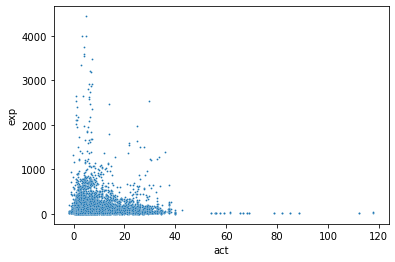

In [12]:
sns.scatterplot(x=activity_df.act, y=expression_df.exp, s=3.5)